# additional work with geopandas

## overview
In this exercise, we'll get some additional practice using `geopandas` and `pandas` to explore spatial (and non-spatial) datasets.

## objectives
- use `pandas` string operations to apply **str** methods to columns of tables
- expand on spatial joins, using representative points instead of centroids to join polygons
- get additional practice with `.groupby` operations
- see how we can join/merge tables using attributes
- compare ways of iterating over **DataFrame** objects
- use some of the `pandas` built-in plotting tools


## data provided

In the data\_files folder, you should have the following files:
-  schools_data.csv
-  transport.csv

We will also make use of the county outlines and 2011 wards boundaries used in previous weeks. 

## getting started

To get started, run the cell below to import both `pandas` and `geopandas`, and load the two spatial datasets we will use at the start. When we load these datasets, we're making sure to re-project them to the same CRS ([EPSG:2157](https://epsg.io/2157), Irish Transverse Mercator) - that way, when we want to plot (or join) the datasets together, we know that they're in the same coordinate system.

In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

counties = gpd.read_file('../Week2/data_files/Counties.shp').to_crs('epsg:2157')
wards = gpd.read_file('../Week3/data_files/NI_Wards.shp').to_crs('epsg:2157')

Let's take a look at the `CountyNames` column of our county attribute table:

In [2]:
counties['CountyName'] # show the county names column from the counties dataset

0         TYRONE
1         ANTRIM
2         ARMAGH
3      FERMANAGH
4    LONDONDERRY
5           DOWN
Name: CountyName, dtype: object

As we output our data for further analysis, including formatting figures, we might not want the county names to be in [shouting case](https://en.wikipedia.org/wiki/All_caps) - that is, we might want to update these to not be in all caps.

We have previously seen how we can use *vectorized* operations on a single column (or multiple columns) of numerical data, but what about **str** objects? For an individual string, we can use a method such as `.title()` ([documentation](https://docs.python.org/3/library/stdtypes.html#str.title)), which converts the string to "title" case (first letter of each word is capitalized, other letters are lowercase). For example:

In [3]:
'TYRONE'.title() # convert the string TYRONE to Tyrone

'Tyrone'

As we have discussed previously, we could iterate over the items in the **Series** - for example, using a *list comprehension*:

```python
not_shouting = [name.title() for name in counties['CountyName']]
```

Another, potentially easier way to do this, is by using `pandas` **str** methods ([documentation](https://pandas.pydata.org/docs/user_guide/text.html#string-methods)). Using the `.str` attribute of (certain types of) **Series** objects, we can use **str** methods such as `.title()`, which will operate on all of the items in the **Series**. For example, to convert each string value in a **Series** to title case, we can use `.str.title()`:

In [4]:
counties['CountyName'].str.title() # convert each string in the series to title case

0         Tyrone
1         Antrim
2         Armagh
3      Fermanagh
4    Londonderry
5           Down
Name: CountyName, dtype: object

To update the `CountyName` column, we can assign the output of `.str.title()` to this column of the **DataFrame**:

In [5]:
counties['CountyName'] = counties['CountyName'].str.title()

Note that the `.str` attribute is only available if the **Series** is of type **object** (or **string**) - it won't work on numeric values:

In [6]:
counties['Area_SqKM'].str.lower() # this won't work, because it's not a string!

AttributeError: Can only use .str accessor with string values!

## spatial joins, revisited

Now that we've further introduced vectorized operations, let's take a moment to remind ourselves what data we're working with. The two files that we have loaded so far, `counties` and `wards`, represent the boundaries of the six counties of Northern Ireland, and the 2011 Census wards and their population, respectively.

To visualize these, we can use the `.plot()` method for a **GeoDataFrame** ([documentation](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoDataFrame.plot.html)), which allows us to make a chloropleth map based on spatial data. To show the outlines of the counties, we'll first use `.boundary` ([documentation](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoSeries.boundary.html)), which returns a **GeoSeries** of **LineString** objects representing the exterior boundary of the polygons:

In [8]:
counties.boundary

0    LINESTRING (639612.43 910662.582, 639617.397 9...
1    MULTILINESTRING ((732420.072 869023.99, 732419...
2    LINESTRING (706593.48 863563.65, 706728.599 86...
3    LINESTRING (619759.712 873025.992, 619777.161 ...
4    LINESTRING (684724.124 939891.235, 684724.744 ...
5    MULTILINESTRING ((725768.785 812618.064, 72576...
dtype: geometry

Putting this all together, we can make a plot that shows the outline of each ward, colored by the population (stretched to saturate between between 1000 and 8000). And, we'll plot the county outlines as a thin red line on the same axis:

[]

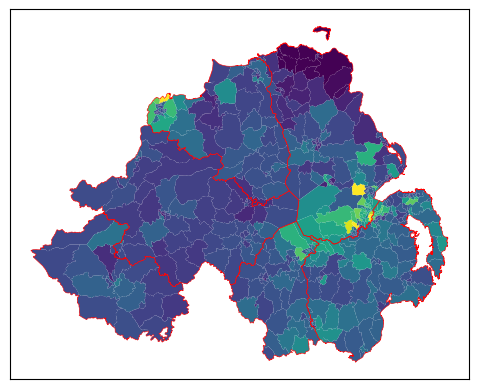

In [9]:
fig, ax = plt.subplots(1, 1) # create a figure and axis object to plot the data into

wards.plot(column='Population', ax=ax, vmin=1000, vmax=8000, cmap='viridis')
counties.boundary.plot(ax=ax, color='r', linewidth=0.4)

ax.set_yticks([]) # turn off the yticks for visibility
ax.set_xticks([]) # turn off the xticks for visibility

As we saw in a previous exercise, we can perform a spatial join using `.sjoin()` ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html)) to join the electoral wards to the county (or counties) that they intersect. Unfortunately, as we also saw, the wards dataset do not fit neatly inside of the county boundaries, in part because of differences in digitizing.

To double check this, let's join the wards to the counties, then compare (a) the number of items in the original dataset to the number of items in the joined datasets; and (b) the total population from the original dataset compared to the total population from the joined dataset:

In [10]:
joined_polygon = counties.sjoin(wards) # join the two datasets using a basic spatial join

print(f"Number of electoral wards: {len(wards)}")
print(f"Number of joined wards: {len(joined_polygon)}")
print('') # prints a blank line
print(f"Total population from wards: {wards['Population'].sum()}")
print(f"Total population from joined: {joined_polygon['Population'].sum()}")

Number of electoral wards: 582
Number of joined wards: 702

Total population from wards: 1810863
Total population from joined: 2213977


From ths, it's clear that we're double-counting lots of wards: from the 582 original wards, we now have 702 in the joined dataset. This (not surprisingly) gives us a total population of 2.21 million, an increase of 21% from the original 1.81 million counted in the 2011 census.

When we are joining two different polygon datasets, it is sometimes preferable to convert one of the datasets to a set of points. This is especially useful in cases where datasets may have been digitized without [snapping](https://www.geographyrealm.com/what-is-snapping-in-gis/) the vertices together, to avoid having gaps or overlaps between features.

Let's try the (obvious) example first, where we use the *centroid*, or centerpoint, of each of the polygons. **GeoDataFrame** and **GeoSeries** objects have a `.centroid` attribute ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.centroid.html)), which gives us a **GeoSeries** of **Point** objects corresponding to the center of each geometry:

In [11]:
wards.centroid # show the centroids of the wards geodataframe

0      POINT (712036.682 902753.166)
1      POINT (709451.109 904430.729)
2       POINT (709181.125 901482.95)
3      POINT (711326.033 901621.974)
4      POINT (708286.653 909943.184)
                   ...              
577    POINT (650617.425 868478.763)
578     POINT (646698.568 873037.48)
579    POINT (680464.207 860299.762)
580    POINT (678809.818 863917.341)
581     POINT (689592.23 865963.847)
Length: 582, dtype: geometry

To visualize this **GeoSeries**, we'll plot the outlines of the wards dataset (again using `.boundary`), along with the centroids of each ward:

[]

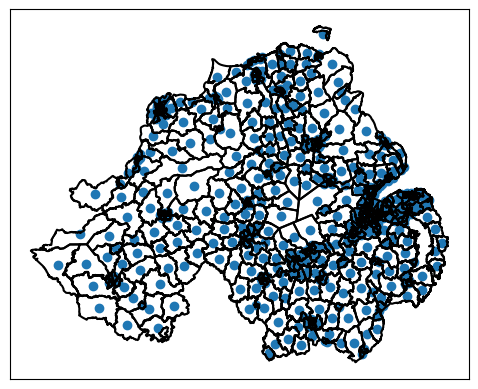

In [12]:
ax = wards.boundary.plot(color='k') # plot the outlines of the counties
wards.centroid.plot(ax=ax) # plot the centroids of each ward

ax.set_yticks([]) # turn off the yticks for visibility
ax.set_xticks([]) # turn off the xticks for visibility

And here, we see one of the potential pitfalls of using the centroid (noted, in fact, at the very top of the documentation page linked above):

> Note that centroid does not have to be on or within original geometry.

You can see this most clearly for Bonamargy and Rathlin in the northernmost part of the map above. Because this ward is split between two features ([Rathlin Island and part of the town of Ballycastle](https://www.openstreetmap.org/#map=12/55.2558/-6.2262)), the centerpoint ends up being somewhere between them in Rathlin Sound.

In fact, there are a number of wards where the centroid is not actually within the original geometry - we can view this by using `.loc` along with `.contains()` ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.contains.html)):

```python
wards['geometry'].contains(wards.centroid)
```

This gives us a boolean (True/False) **Series**, with a value of `True` where the original feature contains its centroid, and a value of `False` otherwise. To view the opposite, we can use the `~` ("bitwise negation") operator, which will invert the selection to show us only the rows where the centroid is not contained in the original feature:

In [ ]:
wards.loc[~wards['geometry'].contains(wards.centroid)] # show the wards whose centroid is not contained within the boundary

We can see that in fact there are 5 different wards where the centroid is not contained in the original feature.

Furthermore, some centroids may not even fall within the county outlines - something that we can check using `.within()` ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.within.html)). Similar to `.contains()`, `.within()` returns a boolean **Series** with a value of `True` where the original feature is *within* (i.e., fully contained inside of) some other geometry or **GeoSeries**.

To check whether the centroids fall within *any* of the county boundaries, we can use `.union_all()` ([documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.union_all.html)), which returns the union of all of the geometries within a **GeoSeries**.

The following cell will show the wards whose centroid is not contained within any of the county boundaries:

In [ ]:
wards.loc[~wards.centroid.within(counties.union_all())] # show the wards whose centroid is not contained within the county boundaries

As we might have suspected, the centroid of Bonamargy and Rathlin, which is located somewhere in Rathlin Sound, is not contained within a county outline - meaning that if we were to join using the centroids, we would be working with an incomplete dataset.

Fortunately, we do have another way to do this, using `.representative_point()` ([documenation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.representative_point.html)). A "representative point" is a point that is guaranteed to be within the original geometry, typically (but not always!) near the middle of the original feature.

First, let's plot the representative points for each ward, alongside the ward outlines and centroids:

In [ ]:
ax = wards.boundary.plot(color='k') # plot the outlines of the counties
wards.representative_point().plot(ax=ax) # plot the representative point of each ward
wards.centroid.plot(marker='.', ax=ax) # plot the centroid as a small dot

ax.set_yticks([]) # turn off the yticks for visibility
ax.set_xticks([]) # turn off the xticks for visibility

For most of the wards, we can see that the representative point and the centroid are in a similar enough location. Now, let's use `.copy()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.copy.html)) to create a copy of the original wards **GeoDataFrame**, then replace the `geometry` of that **GeoDataFrame** with the set of representative points. 

Because later on, we will also want to make use of the area of each ward, we will also add this as a column, using the `.area` attribute of the **GeoSeries** ([documentation](https://geopandas.org/en/latest/docs/reference/api/geopandas.GeoSeries.area.html)). Note that the `.area` attribute is calculated using the CRS of the **GeoSeries** - you'll want to make sure that the dataset is in a *projected* CRS before using this!

Finally, we will perform the spatial join and check the number of features and total population calculated from the joined datasets:

In [ ]:
wards_point = wards.copy()
wards_point['geometry'] = wards.representative_point()
wards_point['area'] = wards['geometry'].area

joined_point = counties.sjoin(wards_point) # join the two datasets using a basic spatial join

print(f"Number of electoral wards: {len(wards)}")
print(f"Number of joined wards: {len(joined_point)}")
print('')
print(f"Total population from wards: {wards['Population'].sum()}")
print(f"Total population from joined: {joined_point['Population'].sum()}")

So now we have joined the wards together with the counties, and the population (and number of features) in the joined dataset matches the original values. With this, we can move on to the next step(s) of our analysis, and look at how we can perform joins on non-spatial attributes.

## non-spatial joins/merges

`pandas` (and, by extension, `geopandas`) offers two main methods for combining tables based on (non-spatial) attributes:

- `pd.merge()` (and `DataFrame.merge()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html))
- `DataFrame.join()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html))

There are (mostly) minor differences between them; `.merge()` is slightly more flexible and is the underlying function used for `.join()`, so we will show examples using this.

### indexing

First, though, let's see how we can use the `index` to add information to a table. In most of the examples that we have seen so far, the `index` of the **DataFrame** has been an integer, usually corresponding to the row number. When we add a **Series** to a **DataFrame**, the values of the **Series** are mapped to the values of the `index` of the **DataFrame**.

To illustrate this more concretely, let's look at an example. We'll first create an empty **DataFrame** with an `index` that ranges from 0 to 3 (remember that `range()` doesn't include the endpoint!).

Then, we'll create two sets of values:

- `ordered`, a **list** of the letters a through d;
- `disordered`, a **Series** that uses the same values as `ordered`, but specifies a different order for the `index` values.

Before running the cell below, be sure to think about what the output should look like. How do you think the two columns of the **DataFrame** will look?

In [ ]:
df = pd.DataFrame(index=range(0, 4))
ordered = ['a', 'b', 'c', 'd']
disordered = pd.Series(data=ordered, index=[3, 0, 2, 1])

df['ordered'] = ordered
df['disordered'] = disordered
print(df)

As we can see from the output above, when we add something to a **DataFrame** without specifying an `index` (i.e., when we add a **list** of values), it defaults to using a numeric `index` that is the same as the index of the original **list**: starting from 0 and incrementing by 1. So, the `index` values of `df['ordered']` are 0, 1, 2, and 3, in that order.

However, we can also specify the `index` values when we create the **Series**, as with `disordered` above. When we do this, and then add `disordered` to the **DataFrame**, we can see that the values are placed in the row of the **DataFrame** corresponding to their `index` - so, 'a' (with an `index` of 3) gets placed in the final row of the **DataFrame**, 'b' (with an `index` of 0) gets placed in the first row, and so on.

Taking this one step further, if we have a dataset with a unique identifier for each row (for example, the `Ward Code`, which uniquely identifies each ward), we can use this as an `index`. Then, when we want to add new data to our table in the form of a **Series**, as long as that **Series** uses the same index values as our **DataFrame**, it will add the **Series** values to the **DataFrame** in the correct order.

To show that this works, let's first sort `joined_point` by the ward name using `.sort_values()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html)):

In [ ]:
joined_point.sort_values('Ward', inplace=True)
joined_point # show that the table is now sorted by ward name

Next, we'll use `.set_index()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html)) to make `Ward Code` the `index` of both `joined_point` and `wards`. Then, we'll add the name of the county where each ward is located (`CountyName`) to the ward **GeoDataFrame**. We should see that, even though `joined_point` has been sorted, the `County` column in the ward **GeoDataFrame** keeps the original (non-sorted) order:

In [ ]:
joined_point.set_index('Ward Code', inplace=True)
wards.set_index('Ward Code', inplace=True)

wards['County'] = joined_point['CountyName']
wards # show the wards dataset, with the new column

If you look at the order of `joined_point` that we saw previously, you should be able to see that the order of `joined_point['CountyName']` is not the same as the order of `wards['County']`: the first three county names are Antrim, Armagh, and Antrim, whereas the first three county names in `wards['County']` are all Antrim.

### types of joins/merges

So far, we've seen how we can use `index` values to add information to a (**Geo**)**DataFrame**. But, we might not always have a clear one-to-one relationship between two tables - we might have a one-to-many relationship, where a single row in one table corresponds to multiple rows in another table. In those cases, we'll use something like `pd.merge()`, which allows us to merge rows of tables together using different index-like values.

The example dataset that we'll work with here is a compilation of school and student numbers for each of our different electoral wards. Using the [school location dataset](https://www.opendatani.gov.uk/@department-of-education/locate-a-school) provided by OpenDataNI, I have summarized the number of schools (divided into primary schools, non-grammar secondary schools, and grammar schools) found in each electoral ward, along with the total number of students in those categories. I also used the [library locations](https://www.opendatani.gov.uk/@libraries-ni/library-locations-ni)  dataset to count the number of libraries found in each electoral ward.

To get started, let's first read **data_files/schools_data.csv** as a `pandas` **DataFrame**, then view what this looks like:

In [ ]:
schools_data = pd.read_csv('data_files/schools_data.csv')
schools_data

Let's start by looking at what happens when we use `pd.merge()`. At a minimum, we need to specify `left_df` and `right_df` - in this case, `wards_point` and `schools_data`. We also want to make sure that we're merging using `Ward Code`, so we pass that as the `on` parameter. 

Note that if we don't specify `on`, `pd.merge()` uses the intersection of the columns of the two **DataFrame**s in order to do the merge - unless you're absolutely sure that there is only one column that is shared between the two **DataFrame**s, and that there are common values in that column in each **DataFrame**, it's better to be explicit!

Run the following cell to see what the output of the merge looks like:

In [ ]:
pd.merge(wards_point, schools_data, on='Ward Code')

Our resulting table only has 486 rows in it - we've lost almost 100 rows from our original wards table. 

To figure out why this is, let's look at the types of join that we have available. From the documentation linked above, the default value for the `how` parameter of `pd.merge()` is `'inner'`, meaning that by default, `pd.merge()` uses an "inner" join. What is an "inner" join? We can see an explanation from the documentation linked above:

> - **inner**: use intersection of keys from both frames, similar to a SQL inner join; preserve the order of the left keys.

So an "inner" join uses the intersection of keys from both frames. In our example above, the result of our merge operation is only those 486 wards that have at least one school or library - wards without a school or library are not included in **schools_data.csv**, so we don't have them in our final, merged, table.

To see how we can merge the two dataframes but still keep wards without schools or libraries, let's look at the list of all of the accepted values of `how` that we can use to tell `pd.merge()` how to merge the two **DataFrame**s:

> - **left**: use only keys from left frame, similar to a SQL left outer join; preserve key order.
> - **right**: use only keys from right frame, similar to a SQL right outer join; preserve key order.
> - **outer**: use union of keys from both frames, similar to a SQL full outer join; sort keys lexicographically.
> - **inner**: use intersection of keys from both frames, similar to a SQL inner join; preserve the order of the left keys.
> - **cross**: creates the cartesian product from both frames, preserves the order of the left keys.

One of these in particular stands out - the `'outer'` join, which uses the union of keys from both **DataFrame**s. We could also use the `'right'` join, though if there are keys in the left **DataFrame** that aren't in the right **DataFrame**, we end up losing information as well. That's not an issue in this case, since the right **DataFrame** contains all possible ward codes, but it's something to keep in mind for other datasets.

Let's see what the output of `pd.merge()` looks like when we specify `how='outer'`:

In [ ]:
pd.merge(wards_point, schools_data, on='Ward Code', how='outer')

Here, we can see one other potential issue: by default, when `pd.merge()` adds a row where values are missing in one of the **DataFrame**s, it inserts those values as `NaN` ("not a number"). Among other things, this can mean that calculations involving those columns end up with `NaN` values.

In general, the way to handle `NaN` or missing values is potentially an entire module of its own, as it has different implications for the resulting calculations. `pandas` has a [good explainer](https://pandas.pydata.org/docs/user_guide/missing_data.html) for how missing values propagate through different calculations, and different ways to handle them. You should think carefully about whether and how to fill, ignore, or drop missing values on a case-by-case basis, based on why those values are missing.

Here, because we know that those values are missing because there are no schools or libraries in those wards, we will use `.fillna()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html)) to give those cells a value of 0. Finally, we will cast the output of this as a **GeoDataFrame**, to help preserve the spatial dimension of our data:

In [ ]:
wards_schools = gpd.GeoDataFrame(pd.merge(wards_point, schools_data, on='Ward Code', how='outer').fillna(0))
wards_schools

Before we join our school and ward dataset to the county dataset, let's first take a moment to add two additional columns, using `.sum()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sum.html)).

The first column, `'schools'`, will be the total number of schools (of any type) in the ward. The second column, `'students'`, will be the total number of students (of any type) in the ward. To calculate these, we first have to select those columns that represent the three types of schools (or students), then calculate the sum using `.sum()`.

Note, however, that the default behavior of `.sum()` is to calculate the sum across rows; here, we want to calculate the sum across columns, so that the end result is the number of schools (or students) in each ward. To do that, we need to pass `axis=1` to `.sum()`, as you can see below:

In [ ]:
wards_schools['schools'] = wards_schools[['primary_schools', 'grammar_schools', 'secondary_schools']].sum(axis=1)
wards_schools['students'] = wards_schools[['primary_students', 'grammar_students', 'secondary_students']].sum(axis=1)

wards_schools

Hopefully, in looking at the examples above, you can see that this has worked - the value of `'schools'` in row 579 is 2, as this ward has one primary school and one secondary school; similarly, there are 2161 students, based on 622 primary students and 1539 secondary students.

Finally, we are ready to perform a spatial join of our combined wards and schools datasets, with the county outlines. When we do this, we will make sure to only select the relevant columns from `counties` (`CountyName`, `Area_SqKM`, and `geometry`). We'll then set the `Ward Code` as the `index` for the **GeoDataFrame**, and remove the `index_right` column since we don't need to keep track of the original row number.

In [ ]:
county_schools = counties[['CountyName', 'Area_SqKM', 'geometry']].sjoin(wards_schools)
county_schools.set_index('Ward Code', inplace=True) # set the index to be the ward code
county_schools.drop(columns=['index_right'], inplace=True) # drop the original index from our wards_schools dataset

county_schools # show the joined dataset

## summarizing and grouping datasets

Now that we have finished preparing our dataset, let's work on starting to analyze what we have. First, we'll have a look at `.describe()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)), which provides a summary of each of the (numeric) columns in the table:

In [ ]:
county_schools.describe()

In the output above, we can see the count (**count**) minimum (**min**), 1st quartile (**25%**), median (**50%**), mean (**mean**), 3rd quartile (**75%**), maximum (**max**), and standard deviation (**std**) values of each numeric variable in the table.

With this, we can quickly see where we might have errors in our data - for example, if we have non-physical or nonsense values in our variables. When first getting started with a dataset, it can be a good idea to check over the dataset using `.describe()`, if you are using it in an interactive environment (such as a jupyter notebook).

Next, we'll see how we can use different tools to aggregate and summarize our data, starting with `.groupby()` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)), which allows us to aggregate the values in the table by grouping rows based on the values found in one or more columns.

To start, we'll group the data by `CountyName`:

In [ ]:
county_groups = county_schools.groupby('CountyName') # create a grouped dataframe

 The output of `.groupby()` is a **DataFrameGroupBy** object, which we can then use to do different calculations based on the groups created. These work in similar ways to a **DataFrame** - for example, we can select an individual column (like `Population`) and calculate the `.sum()` based on which county each ward is located within:

In [ ]:
county_groups['Population'].sum() # get a summary of the population for each county

When we only use a single column from the table, the output is a **Series** with the `index` equal to whatever values make up the groups - in this case, the name of each county.

This means that we can start to build a **DataFrame** that summarizes different columns from our original table, using the county names as an `index`. We'll start with the population, as calculated above:

In [ ]:
summary = pd.DataFrame(index=counties['CountyName']) # create a new summary dataframe
summary['population'] = county_groups['Population'].sum() # get the total population of each county

summary

Next, we can add the area of each county (in square km), and calculate the population density of that county by dividing the population by the area (note that these are *vectorized* operations):

In [ ]:
summary['area'] = counties.set_index('CountyName')['geometry'].area / 1e6 # get the area of each county in square km
summary['density'] = summary['population'] / summary['area'] # calculate population density as the population divided by the area

summary

Then, we can add additional calculations such as the total number of primary schools in each county, as well as the number of primary schools per 1000 residents:

In [ ]:
summary['primary_schools'] = county_groups['primary_schools'].sum()
summary['primary_schools_per_capita'] = summary['primary_schools'] / (summary['population'] / 1000)

summary

... and so on. You should be able to adapt the code snippets shown above to start to work on some of the suggested practice exercises listed at the end of the notebook, to answer some different questions about what this dataset shows.

## iterrows vs. itertuples

One other thing that we'll look at is how we can *iterate* over the rows of a **DataFrame**. Previously, we have seen how in many cases, we can use *vectorized* operations to avoid needing to do this. That said, there are still some cases where we might need to, so let's have a look at two different ways to do this: `.iterrows()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iterrows.html)) and `.itertuples()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.itertuples.html)).

The main differences are:
- `.iterrows()` converts each row into a **Series**, and the **iterator** returns both the `index` and **Series** of each row.
- `.itertuples()` converts each row into a **namedtuple** ([documentation](https://docs.python.org/3/library/collections.html#collections.namedtuple)), which is returned by the **iterator**

`.itertuples()` tends to be a bit faster than `.iterrows()` (because converting the row into a **Series** is a bit slower than converting it into a **namedtuple**). Let's look at how `.iterrows()` works first, by iterating over the 5 wards with the most schools, and printing some information about them:

In [ ]:
print('The wards with the most schools are:')
print('')

top_schools = county_schools.sort_values('schools', ascending=False).head()

for ind, row in top_schools.iterrows():
    print(f"{ind}, {row['Ward']}, County {row['CountyName']}: {int(row['schools'])} schools and {int(row['students'])} students.")

Note the definition of our `for` loop:

```python
for ind, row in top_schools.iterrows():
```

Because the iterating variable of `.iterrows()` is (`index`, **Series**) pairs, we typically use two variables in the definition (here, `ind` and `row`). Inside of the `for` loop, this means that we can make use of both of these variables, and they will be updated each step of the loop.

Notice also that the `index` values of the `row` **Series** are the names of each of the columns of the original **DataFrame** - we can access the individual values from each column of the row using the original column names.

For `.itertuples()`, the iterating variable is a **namedtuple** of the values of the row. We can access the values of a **namedtuple** in two ways:

- using the index value (0, 1, ...), exactly the same way as we would a **tuple**;
- as an **attribute** of the **namedtuple**: for example, `row.column_name`.

Here is the same loop as we saw previously, but this time using `.itertuples()`:

In [ ]:
print('The wards with the most schools are:')
print('')

for ward in top_schools.itertuples():
    print(f"{ward.Index}, {ward.Ward}, County {ward.CountyName}: {int(ward.schools)} schools and {int(ward.students)} students.")

Note that accessing the values of the **namedtuple** as an **attribute** only works if the original column names don't have spaces in them, so it's important to make sure that your column names don't have spaces!

To illustrate what happens if there are spaces, we'll use `.rename()` ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html)) to add a space to the `CountyName` column label:

In [ ]:
top_schools.rename(columns={'CountyName': 'County Name'}, inplace=True)

for ward in top_schools.itertuples(name='Ward'):
    print(ward)

Here, you can see that `'County Name'` has become `'_1'`, which isn't nearly as helpful as something like `'CountyName'`; this is why it's generally a good idea to avoid having spaces for the column names of your **DataFrame** (or **GeoDataFrame**). If you are working with datasets that do have spaces in the column names (or row index), you can use something like the following code to replace spaces with underscores (`'_'`):

In [ ]:
old_names = top_schools.columns # get the column names of the dataframe
new_names = [c.replace(' ', '_') for c in old_names] # replace any space characters with an underscore

top_schools.rename(columns=dict(zip(old_names, new_names)), inplace=True) # use rename to rename the columns
top_schools # show the updated dataframe

This uses a *list comprehension* to replace any space characters with an underscore in each column names (and if there aren't any, it returns the original column name). Then, like we have seen before, we use the output of `zip()` to create a **dict** that we can pass to the `columns` parameter of `.rename()` and update the column names accordingly.

## plotting data

The last thing that we will look at is how to plot some of the results from our **DataFrame**. In the previous exercise, we saw how we can use `matplotlib` directly to plot some of our data. `pandas` (and, as we have seen, `geopandas`) (**Geo**)**DataFrame** objects have a `.plot()` method which allows us to plot our data, without needing to use the `matplotlib` plotting routines directly.

The generic `.plot()` has a number of different plot types that it will produce, using the `kind` parameter:

- **line**: a line plot (also `.plot.line()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.line.html))
- **bar**: a vertical bar plot (also `.plot.bar()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html))
- **barh**: a horizontal bar plot (also `.plot.barh()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.barh.html))
- **hist**: a histogram (also `.plot.hist()` and `.hist()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html))
- **box**: a boxplot (also `.plot.box()` and `.boxplot()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.box.html))
- **kde**: a Kernel Density Estimation plot (also `.plot.kde()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.kde.html))
- **density**: same as **kde** (also `.plot.density()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.density.html))
- **area**: an area plot (also `.plot.area()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.area.html))
- **pie**: a pie plot (also `.plot.pie()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.pie.html))
- **scatter**: a scatter plot (also `.plot.scatter()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html))
- **hexbin**: a hexbin plot (also `.plot.hexbin()`) ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hexbin.html))

Let's have a look at an example using `.hist()`, to show the distribution of the number of schools in each ward. We use the `column` parameter to tell `pandas` which column(s) from our **DataFrame** we want to show the distribution of, and we'll use `range()` to create the bins of our histogram, to range from 0 up to 7:

In [ ]:
county_schools.hist(column='schools', bins=range(0, 8))

If we instead want to compare the histogram for some category (for example, by county), we can use the `by` parameter to tell `pandas` how to group the data before plotting. This will create a separate subplot for each value in the category (i.e., one for each county). 

Note that if we do this, we might also want to use `sharey=True`, so that each panel has the same y-axis so that we can more easily compare them:

In [ ]:
county_schools.hist(column='schools', by='CountyName', bins=range(0, 8), sharey=True)

Finally, let's use our `summary` **DataFrame** to compare the population of each county against the number of primary schools per 1000 residents, using `.plot.scatter()`. 

We'll then assign the output of `.plot.scatter()`, which is a **matplotlib.axes.Axes** object ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.html)), so that we can use `.set_ylabel()` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_ylabel.html)) and `.set_xlabel()` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlabel.html)) to change the default axis labels:

In [ ]:
ax = summary.plot.scatter(x='population', y='primary_schools_per_capita') # make a scatter plot of primary schools per 1000 residents vs population

ax.set_ylabel('Primary Schools per 1000 Residents') # set the y-axis label
ax.set_xlabel('Population') # set the x-axis label

So far, we've seen how to make basic plots using both `matplotlib` and the `pandas`/`geopandas` interface to `matplotlib` functionality. `matplotlib` is a very flexible (almost too flexible) package for making charts and figures, with loads of customizability that you can use to enhance your figures. 

Another package that you might want to have a look at is `seaborn` ([documentation](https://seaborn.pydata.org/)), which is built on top of `matplotlib` and provides a high-level interface for data visualization, using similar syntax to `ggplot2` for the **R** programming language. `seaborn` makes some of the more common customizations much easier than using `matplotlib` or the `pandas` interface, while still providing an easy interface for working with (**Geo**)**DataFrame** objects. 

## next steps

That's all for this practical exercise. If you would like some additional practice, use the datasets that you have already loaded to try to answer the following questions:

- what percentage of each county's population are students in primary/grammar/secondary school?
- which county has the most schools (all types) per capita? is it different for each type of school?
- make a (interactive) map that shows the number of schools in each ward - do you see any differences in the number of schools between urban and rural wards?
- what is the total population who live in a ward with no schools?

### even more practice

For even more additional practice, try the following. In the **data_files** folder, there is an additional file, **transport.csv**, which contains information about the ways that people in each ward travel to work or school. From left to right, the columns tell the number of residents who:

- **residents**: are in school full-time (primary or older), or in work full-time (ages 16-74)
- **work_from_home**: work or study primarily from home
- **train**: primarily take the train to/from work or study
- **bus**: primarily take a bus/minibus/coach to/from work or study
- **motorcycle**: primarily take a motorcycle, scooter, or moped to/from work or study
- **driving**: primarily drive to/from work or study
- **passenger**: primarily ride in a private car to/from work or study
- **carpool**: primarily participate in a carpool to/from work or study
- **taxi**: primarily take a taxi to/from work or study
- **bicycle**: primarily take a bicycle to/from work or study
- **walking**: primarily walk to/from work or study
- **other**: primarily take some other form of transportation to/from work or study
- **public**: primarily take public transportation (e.g., train or bus) to/from work or study

Load this dataset, then merge it to your existing wards data. Then, try to answer the following questions:
- which county has the highest percentage out of all residents who use a bicycle to get to/from work?
- which county has the highest percentage out of all residents who use a bicycle to get to/from work?
- does there appear to be a relationship between bicycle use and public transportation use?
- for each ward, calculate the percentage of residents who study/work full-time who primarily walk to/from school/work. Then, compare the histograms of the percentage of residents who walk between wards with at least one primary school to the wards without a primary school. Does there appear to be a difference between these two distributions?